# UR SLS Sentinel 10m TC

Kode modelling klasifikasi densenet dan resnet urban rural pada data sentinel 2 10m dengan neighbor True crop, input tingkat SLS.

### Import Fast AI

In [ ]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/UR/04. Sentinel 10M SLS TC.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
def plot_multroc(tst_preds, k =5):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots( figsize=(9,7))
    for i in range(0,k):
        fpr, tpr, thresholds = metrics.roc_curve(tst_preds[i][1], tst_preds[i][0][:,1])
        roc_auc = metrics.auc(fpr, tpr)
        viz = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name="ROC fold {}".format(i))
        viz.plot(ax = ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.35,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")

    plt.show()

### Preprocessing Image Input SLS

In [ ]:
path = Path.cwd() / ("04. Sentinel 10M SLS TC")

### Densenet 

Pemodelan di tingat sls dengan densenet

In [ ]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metricsc=[accuracy,bc, Precision(), Recall(),Recall(pos_label=0), f1s, roca]


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
val_pct = []
tst_preds = []
datasetr = []
for kf in range(1,6):
  blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items=get_image_files, # finds the images in the path
                  splitter=FileSplitter("/content/drive/MyDrive/Colab Notebooks/dataset/UR/kfold"+str(kf)+".txt"),  # default random split 80% training, 20% validation
                  get_y=parent_label # extracts the label category from the image's folder name 
                  )
  dls = blocks.dataloaders(path,bs = 768)
  learn = vision_learner(dls, densenet121, metrics=metricsc) 
  learn.fit_one_cycle(4,1e-2)
  preds,label = learn.get_preds(ds_idx  = 1)
  idx_test = []
  for i in dls.valid.items:
      idx_test.append(str(i)[-18:-4])
  true_label = []
  for i in dls.valid.items:
      if("urban" in str(i)) :
          true_label.append(1)
      else :
          true_label.append(0)

  test = pd.DataFrame(preds)
  test["idsls"] = idx_test
  test["true_lab"] = true_label
  test["iddesa"] = test.idsls.str[:10]
  test["stat"] = round(test[1])
  desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})
  desa_pred_test.columns = ["pred","true"]
  desa_pred_test["pred_lab"] = 0
  desa_pred_test["fold"] = kf
  datasetr.append(desa_pred_test)
  desa_pred_test.loc[desa_pred_test.pred > 0.825,"pred_lab"] = 1
  metri = [accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab),balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab),precision_score( desa_pred_test.true,desa_pred_test.pred_lab), recall_score( desa_pred_test.true,desa_pred_test.pred_lab),recall_score( desa_pred_test.true,desa_pred_test.pred_lab,pos_label = 0), f1_score( desa_pred_test.true,desa_pred_test.pred_lab),roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab)]
  val_pct.append(metri)
  tst_preds.append((TensorBase([1-desa_pred_test.pred,desa_pred_test.pred]).T , TensorCategory(desa_pred_test.true)))

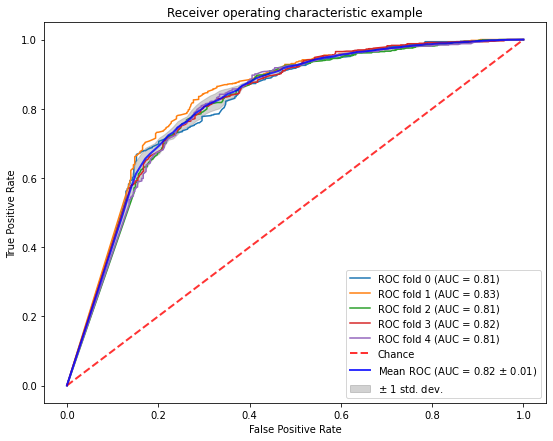

In [ ]:
plot_multroc(tst_preds, k = 5)

In [ ]:
pd.DataFrame(val_pct).mean()

0    0.794626
1    0.741084
2    0.850447
3    0.865644
4    0.616525
5    0.857744
6    0.741084
dtype: float64

In [ ]:
dat = datasetr[0]
for i in range(1,5) :
  dat = pd.concat([dat,datasetr[i]],axis = 0,ignore_index = True)
dat.to_csv("/content/drive/MyDrive/Colab Notebooks/validate/04. fold densenet.csv")

In [ ]:
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/04. densenet.csv")

In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/04. densenet predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)

### Resnet

In [ ]:
val_pct_rs = []
tst_preds_rs = []
datasetr_rs = []
for kf in range(1,6):
  blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items=get_image_files, # finds the images in the path
                  splitter=FileSplitter("/content/drive/MyDrive/Colab Notebooks/dataset/UR/kfold"+str(kf)+".txt"),  # default random split 80% training, 20% validation
                  get_y=parent_label # extracts the label category from the image's folder name 
                  )
  dls = blocks.dataloaders(path,bs = 768)
  learn_rs = vision_learner(dls, resnet50, metrics=metricsc) 
  learn_rs.fit_one_cycle(4,1e-2)
  preds,label = learn_rs.get_preds(ds_idx  = 1)
  idx_test = []
  for i in dls.valid.items:
      idx_test.append(str(i)[-18:-4])
  true_label = []
  for i in dls.valid.items:
      if("urban" in str(i)) :
          true_label.append(1)
      else :
          true_label.append(0)

  test = pd.DataFrame(preds)
  test["idsls"] = idx_test
  test["true_lab"] = true_label
  test["iddesa"] = test.idsls.str[:10]
  test["stat"] = round(test[1])
  desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})
  desa_pred_test.columns = ["pred","true"]
  desa_pred_test["pred_lab"] = 0
  desa_pred_test["fold"] = kf
  datasetr_rs.append(desa_pred_test)
  desa_pred_test.loc[desa_pred_test.pred > 0.825,"pred_lab"] = 1
  metri = [accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab),balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab),precision_score( desa_pred_test.true,desa_pred_test.pred_lab), recall_score( desa_pred_test.true,desa_pred_test.pred_lab),recall_score( desa_pred_test.true,desa_pred_test.pred_lab,pos_label = 0), f1_score( desa_pred_test.true,desa_pred_test.pred_lab),roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab)]
  val_pct_rs.append(metri)
  tst_preds_rs.append((TensorBase([1-desa_pred_test.pred,desa_pred_test.pred]).T , TensorCategory(desa_pred_test.true)))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.410593,0.426650,0.801627,0.630940,0.817533,0.953368,0.308512,0.651422,0.823405,01:33
1,0.396669,0.405251,0.806143,0.686661,0.846163,0.912363,0.460959,0.703054,0.831902,01:29
2,0.376403,0.397195,0.809383,0.671074,0.836965,0.932340,0.409808,0.692505,0.839432,01:29
3,0.364530,0.396989,0.810778,0.666734,0.834433,0.938834,0.394634,0.689446,0.841529,01:29


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.415526,0.407781,0.810215,0.671181,0.840643,0.929450,0.412913,0.691964,0.831544,01:30
1,0.385218,0.406355,0.813688,0.690163,0.850343,0.919624,0.460702,0.708343,0.840952,01:29
2,0.371250,0.393074,0.816223,0.681919,0.845395,0.931403,0.432435,0.703504,0.846744,01:29
3,0.357296,0.392939,0.814721,0.670873,0.839785,0.938086,0.403660,0.693835,0.844605,01:29


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.424049,0.407489,0.811470,0.697371,0.873382,0.891701,0.503041,0.703310,0.829700,01:29
1,0.395355,0.398577,0.819211,0.648508,0.848991,0.939245,0.357770,0.670745,0.836911,01:29
2,0.380024,0.373225,0.821675,0.669390,0.858191,0.928758,0.410023,0.689537,0.845563,01:29
3,0.361919,0.372319,0.820513,0.657285,0.852778,0.935290,0.379279,0.679032,0.844982,01:29


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.415072,0.417969,0.805523,0.656321,0.838248,0.928001,0.384641,0.676100,0.817037,01:30
1,0.376512,0.406530,0.809386,0.661502,0.840323,0.930782,0.392221,0.682236,0.828576,01:30
2,0.367958,0.408442,0.808841,0.645454,0.832482,0.942963,0.347946,0.667504,0.831624,01:30
3,0.354412,0.400725,0.811441,0.654026,0.836327,0.940661,0.367392,0.676529,0.833339,01:30


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.413519,0.405932,0.809274,0.645518,0.841974,0.932186,0.358851,0.665647,0.819265,01:30
1,0.383479,0.404133,0.808456,0.676665,0.857176,0.907376,0.445954,0.690561,0.825073,01:30
2,0.371370,0.390441,0.814664,0.664701,0.850385,0.927224,0.402178,0.684559,0.835926,01:30
3,0.354708,0.389972,0.814303,0.667572,0.851825,0.924436,0.410708,0.686689,0.836103,01:30


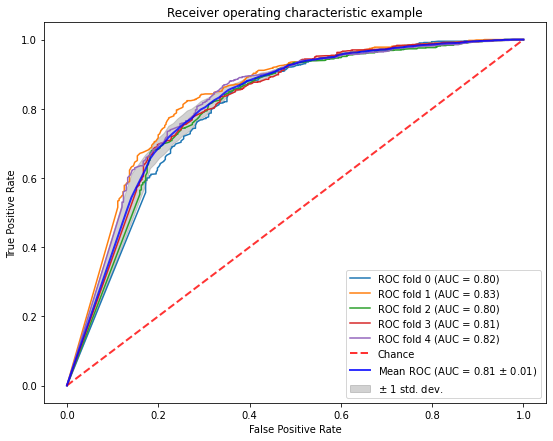

In [ ]:
plot_multroc(tst_preds_rs, k = 5)

In [ ]:
pd.DataFrame(val_pct_rs).mean()

0    0.798219
1    0.746507
2    0.854134
3    0.866277
4    0.626737
5    0.860017
6    0.746507
dtype: float64

In [ ]:
dat_rs = datasetr_rs[0]
for i in range(1,5) :
  dat_rs = pd.concat([dat_rs,datasetr_rs[i]],axis = 0,ignore_index = True)
dat_rs.to_csv("/content/drive/MyDrive/Colab Notebooks/validate/04. fold resnet.csv")

In [ ]:
pd.DataFrame(val_pct_rs).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/04. resnet.csv")

In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/04. resnet predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds_rs, fp)